<a href="https://colab.research.google.com/github/BrMrtn/GoogleColab/blob/main/Cross_valid_Train_Uj_Uj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The code below uses google's bird-vocalization-classifier to filter the likely incorrect data. If the prediction of the model is far from the correct bird species (even when it comes to the family of the species) we get rid of it.

If any secondary label comes out as the prediction of the model, we use switch out the primary label for the secondary.


We needed to check if there is any duplication of titles or audio files among the data.

If there was, we would then remove them from the database, only keeping the first appearance.


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image
from google.colab import drive

# Mount Google Drive to access files
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/DeepLearning'

import hashlib
import shutil

import os
import hashlib

X = []
Y = []

def get_file_hash(file_path):
    hash_md5 = hashlib.md5()  # Create an MD5 hash object to store the file's hash value
    with open(file_path, "rb") as f:
        # Read the file in chunks (4KB at a time) and update the hash
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()  # Return the final hash value as a hexadecimal string

def delete_duplicates_and_log(spectrograms_path):
    global X,Y
    seen_hashes = set()  # This will store the hashes of files we've already processed
    files_to_delete = []  # List to track files that are duplicates and will be deleted
    files_to_keep = []  # List to track files that are unique and will be kept

    # Walk through the folders in the spectrograms directory
    for folder in os.listdir(spectrograms_path):
        folder_path = os.path.join(spectrograms_path, folder)

        # Loop through the files in the current folder
        files = os.listdir(folder_path)
        for file in files:
            if file.endswith('.png'):  # We're only interested in .png files (spectrograms)
                file_path = os.path.join(folder_path, file)

                # Generate a hash for the file to compare it with others
                file_hash = get_file_hash(file_path)

                if file_hash in seen_hashes:
                    # If we've already seen this hash, it's a duplicate
                    print(f"Duplicate file found: {file_path}")
                    files_to_delete.append(file_path)
                else:
                    # If we haven't seen this hash yet, add it to the seen set and keep it
                    seen_hashes.add(file_hash)
                    files_to_keep.append(file_path)

                    img = image.load_img(file_path, target_size=(224, 224), color_mode="rgb")
                    img_array = image.img_to_array(img)
                    X.append(img_array)
                    Y.append(folder)

    # Log files that we kept (not duplicates)
    print("Files kept:")
    for file_path in files_to_keep:
        print(f"   - Keeping file: {file_path}")

    # Log files that we deleted (duplicates)
    print("\nFiles deleted:")
    for file_path in files_to_delete:
        print(f"   - Deleting file: {file_path}")
        os.remove(file_path)  # Actually delete the duplicate files

    # Convert X and Y to numpy arrays
    X = np.array(X)
    Y = np.array(Y)

    # Shuffle the data
    permutation = np.random.permutation(len(X))
    X = X[permutation]
    Y = Y[permutation]

    # Print shapes of the arrays
    print(f"\nX shape: {X.shape}")
    print(f"Y shape: {Y.shape}")

    return X, Y

X, Y = delete_duplicates_and_log(spectrograms_path)



Files kept:
   - Keeping file: /content/drive/MyDrive/DeepLearning/ugyanaz?/blrwar1/XC185002.png
   - Keeping file: /content/drive/MyDrive/DeepLearning/ugyanaz?/blrwar1/XC185455.png
   - Keeping file: /content/drive/MyDrive/DeepLearning/ugyanaz?/blrwar1/XC190758.png
   - Keeping file: /content/drive/MyDrive/DeepLearning/ugyanaz?/blrwar1/XC185454.png
   - Keeping file: /content/drive/MyDrive/DeepLearning/ugyanaz?/blrwar1/XC192131.png
   - Keeping file: /content/drive/MyDrive/DeepLearning/ugyanaz?/blrwar1/XC113371.png
   - Keeping file: /content/drive/MyDrive/DeepLearning/ugyanaz?/blrwar1/XC113345.png
   - Keeping file: /content/drive/MyDrive/DeepLearning/ugyanaz?/blrwar1/XC118223.png
   - Keeping file: /content/drive/MyDrive/DeepLearning/ugyanaz?/blrwar1/XC19604.png
   - Keeping file: /content/drive/MyDrive/DeepLearning/ugyanaz?/blrwar1/XC194051.png
   - Keeping file: /content/drive/MyDrive/DeepLearning/ugyanaz?/blrwar1/XC199244.png
   - Keeping file: /content/drive/MyDrive/DeepLearning

Since this is a multi-class classification task, I am converting labels to one-hot format:

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

#First, the labels need to be converted into numerical values
le = LabelEncoder()
Y_encoded = le.fit_transform(Y)

#Getting number of classes
num_classes = len(le.classes_)
print(f"Class number= {num_classes}")

#Converting to one-hot encoding
Y_onehot = to_categorical(Y_encoded, num_classes)

Class number= 19


We implemented early stopping, in case the model started overfitting.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

#Implementing early stopping, since there is no reason for it to learn further when val_loss isn't decreasing
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5, #If it doesn't improve for 5 epochs, it concludes
    verbose=1,
    restore_best_weights=True
)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint # Importing the missing ModelCheckpoint class

#Wanting to save the best model, so implementing checkpointing
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [ ]:
!pip install efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.8 MB/s eta 0:00:00


We used efficientNetV2 pretrained model, since most kaggle teams suggested it.

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import StratifiedKFold

# Setting up Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []
fold_losses = []
history_per_fold = []

# Starting K-Fold
fold_number = 1
for train_index, valid_index in skf.split(X, Y_encoded):
    print(f"Starting fold: {fold_number}")

    # Splitting the data into training and validation sets
    X_train, X_valid = X[train_index], X[valid_index]
    Y_train, Y_valid = Y_onehot[train_index], Y_onehot[valid_index]

    # Normalizing the data
    X_train = X_train / np.max(X_train)
    X_valid = X_valid / np.max(X_valid)

    # Setting the input shape based on the data
    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

    # Loading the pre-trained EfficientNetV2B0 model
    base_model = EfficientNetV2B0(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )

    # Defining a new model
    model = models.Sequential()

    # Adding the pre-trained model
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())  # Selecting the best representations

    # Adding Dense layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Adding Dropout to prevent overfitting
    model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer

    # Freezing the base model layers if we don't want to update them during training
    base_model.trainable = False

    # Compiling the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Training the model
    history = model.fit(
        X_train, Y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_valid, Y_valid),
        callbacks=[early_stopping, checkpoint],
        verbose=1
    )

    # Saving the results
    history_per_fold.append(history)
    valid_loss, valid_accuracy = model.evaluate(X_valid, Y_valid)

    fold_accuracies.append(valid_accuracy)
    fold_losses.append(valid_loss)

    fold_number += 1

# Summary of the final model
model.summary()

Starting fold: 1
Epoch 1/50
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.1932 - loss: 2.6821

KeyboardInterrupt: 

In [ ]:
print("\nCross-Validation Results:")
print(f"Mean Validation Loss: {np.mean(fold_losses)}")
print(f"Mean Validation Accuracy: {np.mean(fold_accuracies)}")

for i, (loss, accuracy) in enumerate(zip(fold_losses, fold_accuracies), start=1):
    print(f"Fold {i} - Validation Loss: {loss}, Validation Accuracy: {accuracy}")


Cross-Validation Results:
Mean Validation Loss: 2.0392131090164183
Mean Validation Accuracy: 0.38448787927627565
Fold 1 - Validation Loss: 1.6745779514312744, Validation Accuracy: 0.5021644830703735
Fold 2 - Validation Loss: 2.400705575942993, Validation Accuracy: 0.2532467544078827
Fold 3 - Validation Loss: 2.3105974197387695, Validation Accuracy: 0.25813448429107666
Fold 4 - Validation Loss: 2.2607364654541016, Validation Accuracy: 0.31887200474739075
Fold 5 - Validation Loss: 1.5494481325149536, Validation Accuracy: 0.5900216698646545


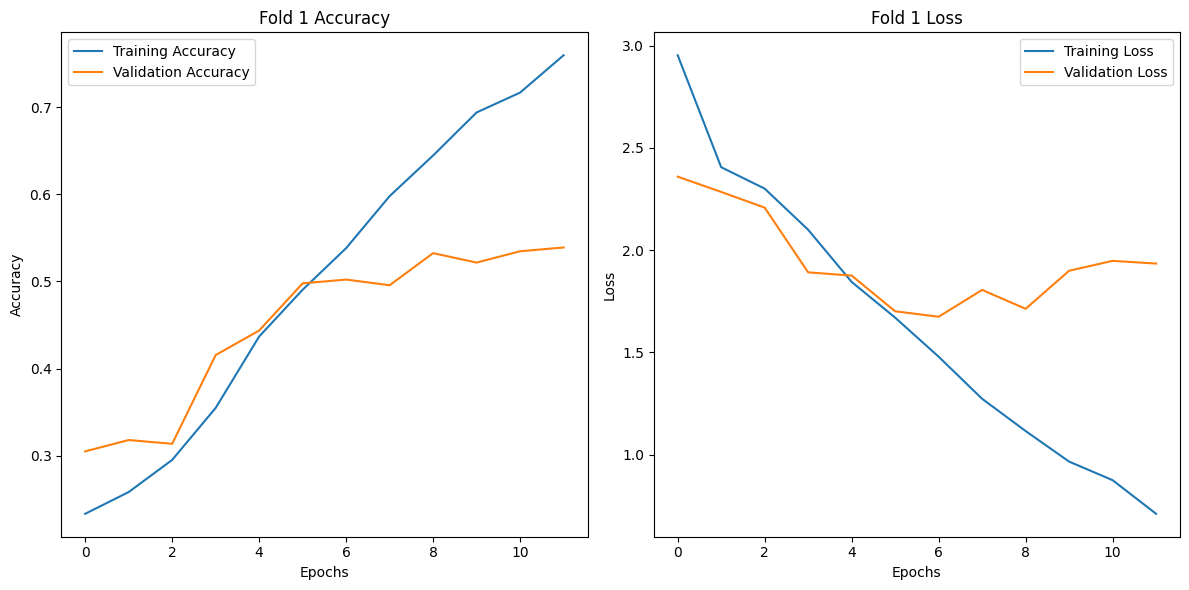

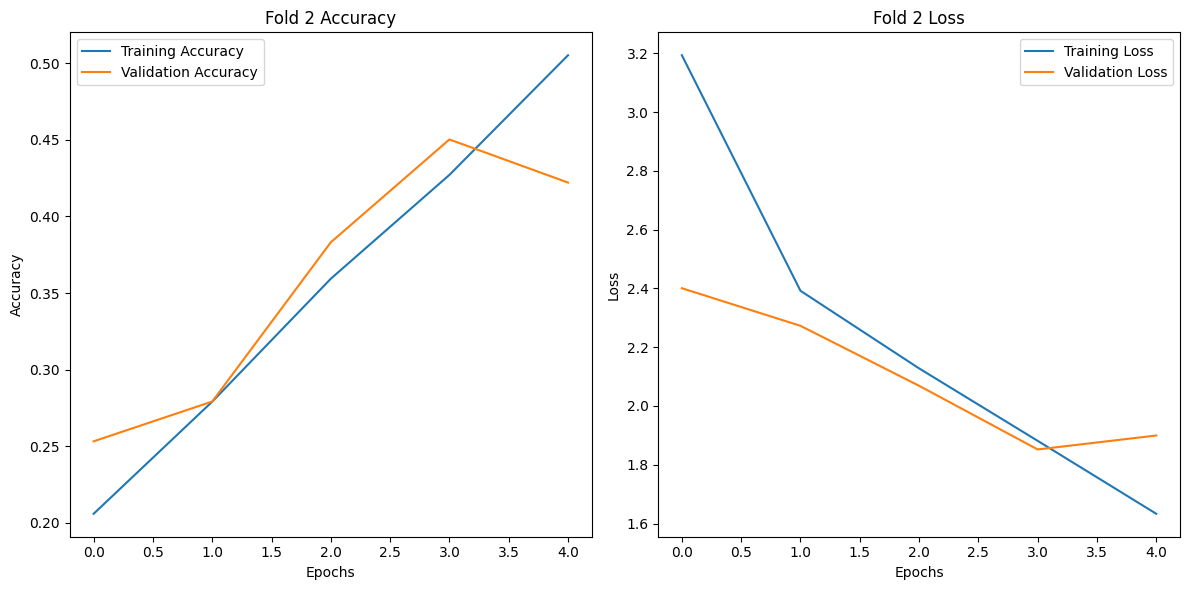

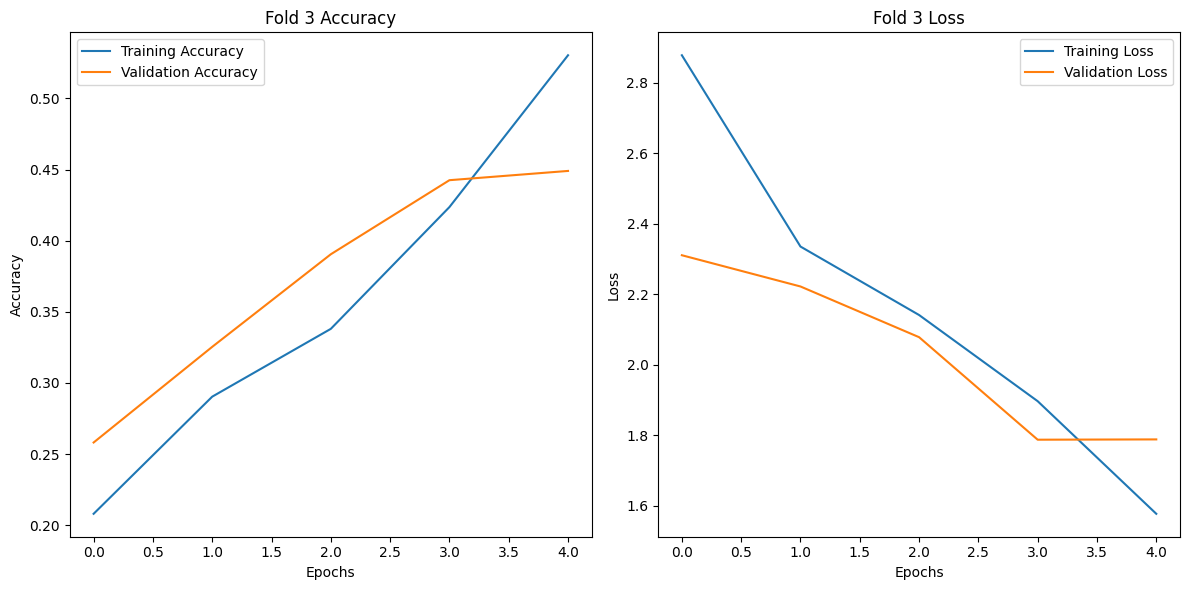

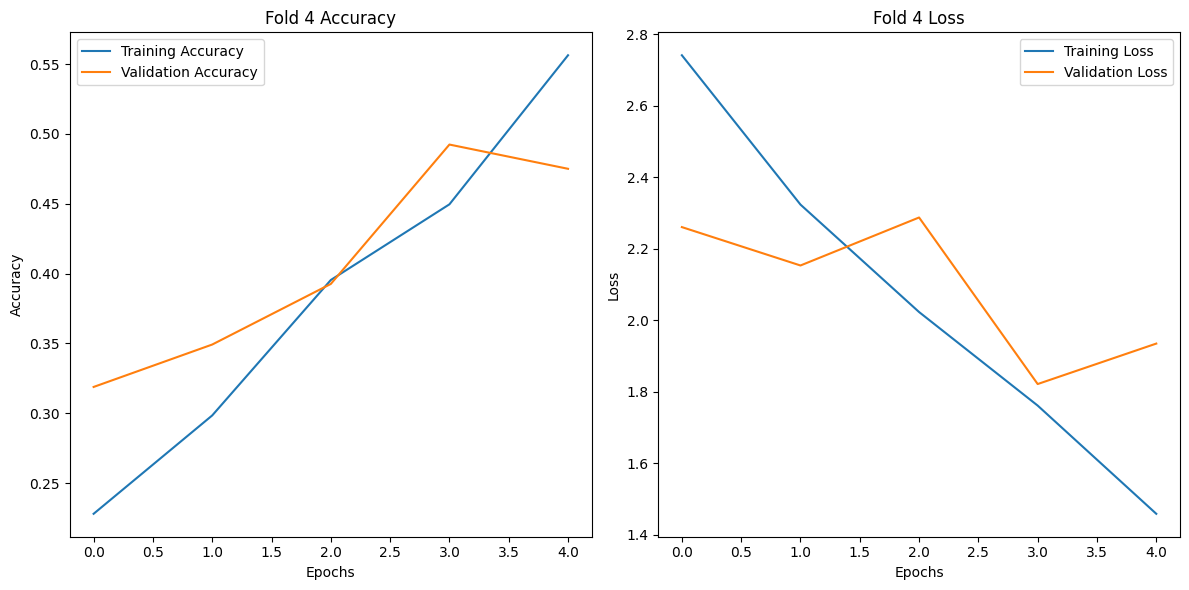

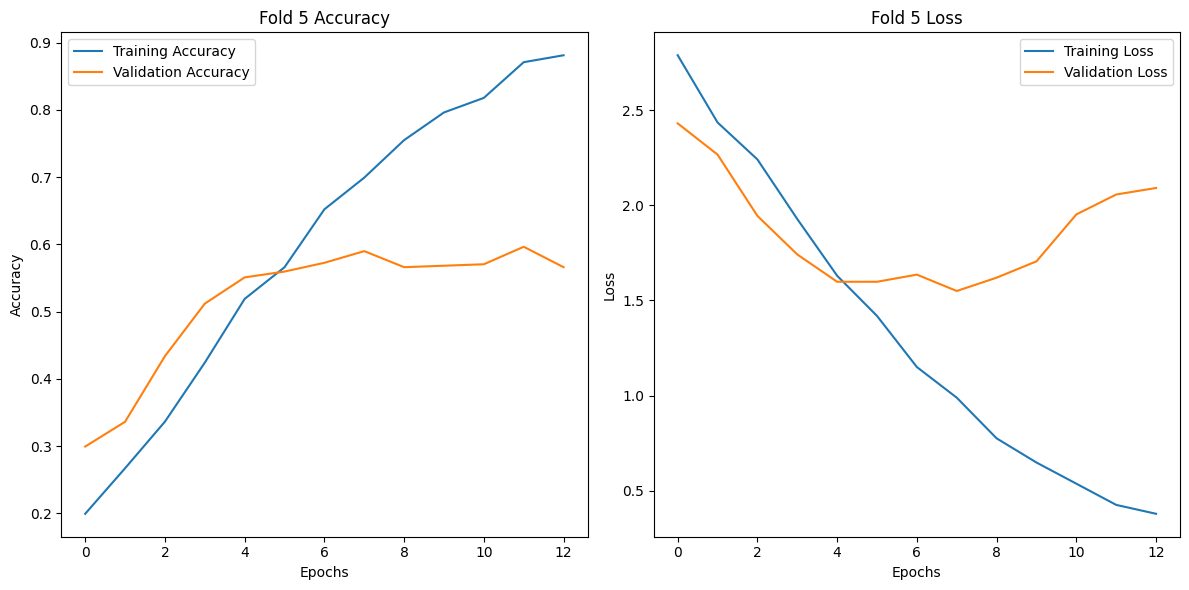

In [ ]:
# Plot loss and accuracy for each fold
for i, history in enumerate(history_per_fold):
  plt.figure(figsize=(12, 6))

  # Plot accuracy
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title(f'Fold {i + 1} Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  # Plot loss
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title(f'Fold {i + 1} Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()